# Speed Time Series Forecasting using XGBoost

In [14]:
#Import library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import plot_importance
import holidays
import datetime
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Data 

In [15]:

# Read training data from csv file
dateparse = lambda dates: pd.datetime.strptime(dates, '%d/%m/%Y %H:%M')
data = pd.read_csv('./5001 kaggle/train.csv', index_col='date',date_parser=dateparse)
# Read hand in testing data from csv file
dateparse = lambda dates: pd.datetime.strptime(dates, '%d/%m/%Y %H:%M')
sample_data = pd.read_csv('./5001 kaggle/test.csv', index_col='date',date_parser=dateparse)

<ipython-input-15-d24050c7ad84>:2: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  dateparse = lambda dates: pd.datetime.strptime(dates, '%d/%m/%Y %H:%M')
<ipython-input-15-d24050c7ad84>:5: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  dateparse = lambda dates: pd.datetime.strptime(dates, '%d/%m/%Y %H:%M')


In [16]:
data

,id,speed
date,,
2017-01-01 00:00:00,0,43.002930
2017-01-01 01:00:00,1,46.118696
2017-01-01 02:00:00,2,44.294158
2017-01-01 03:00:00,3,41.067468
2017-01-01 04:00:00,4,46.448653
...,...,...
2018-12-31 12:00:00,14001,19.865269
2018-12-31 15:00:00,14002,17.820375
2018-12-31 16:00:00,14003,12.501851


In [17]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 14006 entries, 2017-01-01 00:00:00 to 2018-12-31 20:00:00
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      14006 non-null  int64  
 1   speed   14006 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 328.3 KB


In [5]:
# use hk_holidays list to append the hong kong holidays 
# hk_holidays=[]
# for date in holidays.HongKong(years=2020).items():
#      hk_holidays.append(str(date[0]))
hk_holidays = ['2017-01-02', '2017-01-28', '2017-01-30', '2017-01-31', '2017-04-04', '2017-04-14', '2017-04-15', '2017-04-17', '2017-05-03', '2017-05-01', '2017-05-30', '2017-07-01', '2017-10-05', '2017-10-02', '2017-10-28', '2017-12-25', '2017-12-26', '2018-01-01', '2018-02-16', '2018-02-17', '2018-02-19', '2018-04-05', '2018-03-30', '2018-03-31', '2018-04-02', '2018-05-22', '2018-05-01', '2018-06-18', '2018-07-02', '2018-09-25', '2018-10-01', '2018-10-17', '2018-12-25', '2018-12-26', '2019-01-01', '2019-02-05', '2019-02-06', '2019-02-07', '2019-04-05', '2019-04-19', '2019-04-20', '2019-04-22', '2019-05-13', '2019-05-01', '2019-06-07', '2019-07-01', '2019-09-14', '2019-10-01', '2019-10-07', '2019-12-25', '2019-12-26', '2020-01-01', '2020-01-25', '2020-01-27', '2020-01-28', '2020-04-04', '2020-04-10', '2020-04-11', '2020-04-13', '2020-04-30', '2020-05-01', '2020-06-25', '2020-07-01', '2020-10-02', '2020-10-01', '2020-10-26', '2020-12-25', '2020-12-26']

# Create Time Series Features

In [18]:
# Since the training data have only datetime feature,we need to create features based on this datetime column
def create_features(df, label=None):
    df['date'] = df.index # index: DatetimeIndex
    df['hour'] = df['date'].dt.hour # dt: DatetimeProperties, hour: Series
    df['day_of_week'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['day_of_year'] = df['date'].dt.dayofyear
    df['day_of_month'] = df['date'].dt.day
    df['week_of_year'] = df['date'].dt.weekofyear
    df['holidays'] = [1 if str(val).split()[0] in hk_holidays else 0 for val in df.index]

    X = df[['hour', 'day_of_week', 'quarter', 'month', 'year', 'day_of_year', 'day_of_month', 'week_of_year','holidays']]
    if label:
        y = df[label]
        return X, y
    return X

In [19]:
# Train/Test Split 
# Since the training dataset is small, we use 1 month data to be the testing dataset
test = data[data.index>="2018-12-01"]
# Testing dataset with implemented features engineering
X_test, y_test = create_features(test, label='speed')

# Since the training dataset is small, we use whole datset to fit the models
X_all,y_all = create_features(data,label='speed')

# Create feature for hand_in dataset
X_sample_data = create_features(sample_data)
# train = data[data.index<"2018-12-01"]
# X_train, y_train = create_features(train, label='speed')

<ipython-input-18-43c987ee96bb>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = df.index # index: DatetimeIndex
<ipython-input-18-43c987ee96bb>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['hour'] = df['date'].dt.hour # dt: DatetimeProperties, hour: Series
<ipython-input-18-43c987ee96bb>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pand

In [23]:
# The detail information after creating feature
X_test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 412 entries, 2018-12-01 00:00:00 to 2018-12-31 20:00:00
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   hour          412 non-null    int64
 1   day_of_week   412 non-null    int64
 2   quarter       412 non-null    int64
 3   month         412 non-null    int64
 4   year          412 non-null    int64
 5   day_of_year   412 non-null    int64
 6   day_of_month  412 non-null    int64
 7   week_of_year  412 non-null    int64
 8   holidays      412 non-null    int64
dtypes: int64(9)
memory usage: 32.2 KB


In [24]:
X_test

,hour,day_of_week,quarter,month,year,day_of_year,day_of_month,week_of_year,holidays
date,,,,,,,,,
2018-12-01 00:00:00,0,5,4,12,2018,335,1,48,0
2018-12-01 01:00:00,1,5,4,12,2018,335,1,48,0
2018-12-01 05:00:00,5,5,4,12,2018,335,1,48,0
2018-12-01 06:00:00,6,5,4,12,2018,335,1,48,0
2018-12-01 07:00:00,7,5,4,12,2018,335,1,48,0
...,...,...,...,...,...,...,...,...,...
2018-12-31 12:00:00,12,0,4,12,2018,365,31,1,0
2018-12-31 15:00:00,15,0,4,12,2018,365,31,1,0
2018-12-31 16:00:00,16,0,4,12,2018,365,31,1,0


# Create XGBoost Model

In [25]:
# n_estimators=300, min_child_weight=2, max_depth=24,reg_alpha=9 #score 9.80290
# n_estimators=300, min_child_weight=2, max_depth=28,reg_alpha=9 #score 9.83055
# n_estimators=300, min_child_weight=2, max_depth=26,reg_alpha=9 #score 9.74110
# n_estimators=300, min_child_weight=2, max_depth=27,reg_alpha=9 #score 9.68809
reg = xgb.XGBRegressor(n_estimators=300, min_child_weight=2, max_depth=27,reg_alpha=9)
reg.fit(X_all, y_all,verbose=False)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=27,
             min_child_weight=2, missing=nan, monotone_constraints='()',
             n_estimators=300, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=9, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

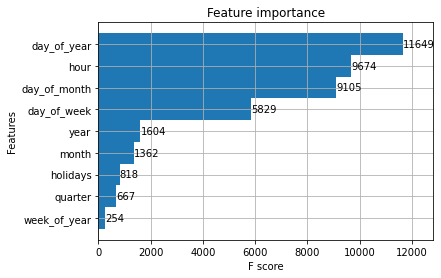

In [26]:
_ = plot_importance(reg, height=1.0)

# Error Metrics On Test Set

In [27]:
mean_squared_error(y_true=y_test,
                   y_pred=reg.predict(X_test))

2.1049266651932927

# Predict Hand_in Testing Data

In [28]:
# Predict the hand in testing data 
X_handin_1 = reg.predict(X_sample_data)
df = pd.DataFrame(data=X_handin_1, columns=["speed"])

In [29]:
df

,speed
0,48.093746
1,47.916363
2,39.133141
3,27.871517
4,40.892269
...,...
3499,12.652089
3500,25.779325
3501,46.185123
3502,41.804634


In [30]:
# Output the submission data
df = df.reset_index()
df = df.rename(columns={'index': 'id'})
df.to_csv('Submission.csv',index=False)